## 1. Import Libraries

In [1]:
import sys
parentdir = ".."
sys.path.insert(0, parentdir)

import requests
import os
import datetime
#from os import path
from tqdm.notebook import tqdm
import pandas as pd
import time

from metrics.WebResource import WebResource
from rdflib import Graph
from xml.dom import minidom
from rdflib import ConjunctiveGraph, Namespace, URIRef
from rdflib.namespace import RDF, RDFS

import random
import matplotlib.pyplot as plt

from SPARQLWrapper import SPARQLWrapper, JSON

from rdflib import Graph, URIRef
from rdflib.namespace import RDFS, SKOS

/Users/frikha-s/opt/anaconda3/envs/fair-checker-env/lib/python3.8/site-packages/rdflib_jsonld/__init__.py:9: DeprecationWarning: The rdflib-jsonld package has been integrated into rdflib as of rdflib==6.0.1.  Please remove rdflib-jsonld from your project's dependencies.
  warnings.warn(
[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 105.0.5195
[WDM] - Get LATEST driver version for 105.0.5195
[WDM] - Driver [/Users/frikha-s/.wdm/drivers/chromedriver/mac64/105.0.5195.52/chromedriver] found in cache


## 2. Retrieve a List of Target URLs

In [2]:
# parse the xml file
mydoc = minidom.parse('Sitemap.xml')
urls = mydoc.getElementsByTagName('ExpertLink')

with open('URLs.txt', 'w') as f:
    for u in urls:
        f.write(u.firstChild.data)
        f.writelines('\n')

In [3]:
mydoc = open('URLs.txt', 'r')
urls = mydoc.readlines()

## 3. Feed the RDF Graph

In [4]:
schema = Namespace("http://schema.org/")

In [5]:
## ratelimit decorator
from ratelimit import limits, RateLimitException, sleep_and_retry

five_by_seconds = 0.8

@sleep_and_retry
@limits(calls=1, period=five_by_seconds)
def ask_orphanet(u):
    wr = WebResource(url=u)
    return wr.get_rdf()

In [6]:
%%time
KG_Total = ConjunctiveGraph()

for u in tqdm(urls):
    KG_Total += ask_orphanet(u)

  0%|          | 0/10617 [00:00<?, ?it/s]

<class 'dict'>
{'@context': 'http://schema.org/', '@type': 'MedicalCondition', '@id': 'http://www.orpha.net/consor/cgi-bin/OC_Exp.php?lng=en&Expert=166032', 'identifier': '166032', 'name': {'@type': 'PronounceableText', 'inLanguage': 'EN', 'textValue': 'Multiple epiphyseal dysplasia, with miniepiphyses'}, 'alternateName': [], 'epidemiology': 'Prevalence : <1 / 1 000 000', 'code': [{'@type': 'MedicalCode', 'codeValue': 'ORPHA:166032', 'codingSystem': 'ORPHAcode'}, {'@type': 'MedicalCode', 'codeValue': 'Q77.3', 'codingSystem': 'ICD-10'}, {'@type': 'MedicalCode', 'codeValue': '609325', 'codingSystem': 'OMIM'}, {'@type': 'MedicalCode', 'codeValue': 'C1836307', 'codingSystem': 'UMLS'}], 'description': 'Multiple epiphyseal dysplasia, with miniepiphyses is a rare primary bone dysplasia disorder characterized by strikingly small secondary ossification centers (mini-epiphyses) in all or only some joints, resulting in severe bone dysplasia of the proximal femoral heads. Short stature, increased 

/Users/frikha-s/opt/anaconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.orpha.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<class 'dict'>
{'@context': 'http://schema.org/', '@type': 'MedicalCondition', '@id': 'http://www.orpha.net/consor/cgi-bin/OC_Exp.php?lng=en&Expert=61', 'identifier': '61', 'name': {'@type': 'PronounceableText', 'inLanguage': 'EN', 'textValue': 'Alpha-mannosidosis'}, 'alternateName': ['Lysosomal alpha-D-mannosidase deficiency'], 'epidemiology': 'Prevalence : 1-9 / 1 000 000', 'code': [{'@type': 'MedicalCode', 'codeValue': 'ORPHA:61', 'codingSystem': 'ORPHAcode'}, {'@type': 'MedicalCode', 'codeValue': 'E77.1', 'codingSystem': 'ICD-10'}, {'@type': 'MedicalCode', 'codeValue': '248500', 'codingSystem': 'OMIM'}, {'@type': 'MedicalCode', 'codeValue': 'C0024748', 'codingSystem': 'UMLS'}, {'@type': 'MedicalCode', 'codeValue': 'D008363', 'codingSystem': 'MeSH'}, {'@type': 'MedicalCode', 'codeValue': '6968', 'codingSystem': 'GARD'}], 'description': 'An inherited lysosomal storage disorder characterized by immune deficiency, facial and skeletal abnormalities, hearing impairment, and intellectual 

/Users/frikha-s/opt/anaconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.orpha.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<class 'dict'>
{'@context': 'http://schema.org/', '@type': 'MedicalCondition', '@id': 'http://www.orpha.net/consor/cgi-bin/OC_Exp.php?lng=en&Expert=166029', 'identifier': '166029', 'name': {'@type': 'PronounceableText', 'inLanguage': 'EN', 'textValue': 'Multiple epiphyseal dysplasia, with severe proximal femoral dysplasia'}, 'alternateName': [], 'epidemiology': 'Prevalence : <1 / 1 000 000', 'code': [{'@type': 'MedicalCode', 'codeValue': 'ORPHA:166029', 'codingSystem': 'ORPHAcode'}, {'@type': 'MedicalCode', 'codeValue': 'Q77.3', 'codingSystem': 'ICD-10'}, {'@type': 'MedicalCode', 'codeValue': '609324', 'codingSystem': 'OMIM'}, {'@type': 'MedicalCode', 'codeValue': 'C1836315', 'codingSystem': 'UMLS'}], 'description': 'Multiple epiphyseal dysplasia, with severe proximal femoral dysplasia is a rare primary bone dysplasia characterized by severe, early-onset dysplasia of the proximal femurs, with almost complete absence of the secondary ossification centers and abnormal development of the 

/Users/frikha-s/opt/anaconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.orpha.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<class 'dict'>
{'@context': 'http://schema.org/', '@type': 'MedicalCondition', '@id': 'http://www.orpha.net/consor/cgi-bin/OC_Exp.php?lng=en&Expert=166038', 'identifier': '166038', 'name': {'@type': 'PronounceableText', 'inLanguage': 'EN', 'textValue': 'Metaphyseal chondrodysplasia, Kaitila type'}, 'alternateName': [], 'epidemiology': 'Prevalence : <1 / 1 000 000', 'code': [{'@type': 'MedicalCode', 'codeValue': 'ORPHA:166038', 'codingSystem': 'ORPHAcode'}, {'@type': 'MedicalCode', 'codeValue': 'Q78.5', 'codingSystem': 'ICD-10'}, {'@type': 'MedicalCode', 'codeValue': '250230', 'codingSystem': 'OMIM'}, {'@type': 'MedicalCode', 'codeValue': 'C1855217', 'codingSystem': 'UMLS'}], 'description': 'Metaphyseal chondrodysplasia, Kaitila type is a rare multiple metaphyseal dysplasia disease characterized by disproportionate short stature, short limbs and digits, tracheobronchial malacia and progressive thoracolumbar scoliosis. Radiographic imaging shows progression from marked metaphyseal dyspla

/Users/frikha-s/opt/anaconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.orpha.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<class 'dict'>
{'@context': 'http://schema.org/', '@type': 'MedicalCondition', '@id': 'http://www.orpha.net/consor/cgi-bin/OC_Exp.php?lng=en&Expert=93', 'identifier': '93', 'name': {'@type': 'PronounceableText', 'inLanguage': 'EN', 'textValue': 'Aspartylglucosaminuria'}, 'alternateName': ['Aspartylglucosaminidase deficiency'], 'epidemiology': 'Prevalence : Unknown', 'code': [{'@type': 'MedicalCode', 'codeValue': 'ORPHA:93', 'codingSystem': 'ORPHAcode'}, {'@type': 'MedicalCode', 'codeValue': 'E77.1', 'codingSystem': 'ICD-10'}, {'@type': 'MedicalCode', 'codeValue': '208400', 'codingSystem': 'OMIM'}, {'@type': 'MedicalCode', 'codeValue': 'C0268225', 'codingSystem': 'UMLS'}, {'@type': 'MedicalCode', 'codeValue': 'C2931840', 'codingSystem': 'UMLS'}, {'@type': 'MedicalCode', 'codeValue': 'C538402', 'codingSystem': 'MeSH'}, {'@type': 'MedicalCode', 'codeValue': 'D054880', 'codingSystem': 'MeSH'}, {'@type': 'MedicalCode', 'codeValue': '5854', 'codingSystem': 'GARD'}, {'@type': 'MedicalCode', '

/Users/frikha-s/opt/anaconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.orpha.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


KeyboardInterrupt: 

In [7]:
##Display the total triples contained in the graph, after scrapping all URLs in the XML file
print(f"Loaded {len(KG_Total)} triples")

Loaded 278 triples


In [ ]:
#Save the KG in a turtle file
KG_Total.serialize("new_orphanet_dump.ttl", format="turtle")

In [ ]:
!cat new_orphanet_dump.ttl

In [8]:
#Display the file's size
#!cat scrapped_orphanet_bioschemas.ttl
from pathlib import Path
file_size =Path(r'new_orphanet_dump.ttl').stat().st_size
print("The file size is:", file_size,"bytes")

The file size is: 5488367 bytes


## 5. Display Bioschemas Properties Counts

In [9]:
def get_dataframe_from_query_results(res):    
    return pd.DataFrame(res.bindings)

In [11]:
### display used properties
property_counts = """
SELECT ?p (count(?p) as ?count) WHERE {
    ?s ?p ?o .
} 
GROUP BY ?p
ORDER BY DESC(?count)
"""

res = KG_Total.query(property_counts)
print(res)
print("********** Used properties **********")
df = get_dataframe_from_query_results(res)
df

********** Used properties **********


,count,p
0,69,http://www.w3.org/1999/02/22-rdf-syntax-ns#type
1,54,http://schema.org/code
2,54,http://schema.org/codeValue
3,54,http://schema.org/codingSystem
4,10,http://schema.org/textValue
5,10,http://schema.org/inLanguage
6,10,http://schema.org/name
7,5,http://schema.org/epidemiology
8,5,http://schema.org/description
9,5,http://schema.org/identifier


## 6. Display Bioschemas Classes Counts

In [12]:
### display used classes
classes_counts = """
SELECT ?c (count(?c) as ?count) WHERE {
    ?s rdf:type ?c .
} 
GROUP BY ?c
ORDER BY DESC(?count)
"""

res = KG_Total.query(classes_counts)
print()
print("********** Used classes **********")
df = get_dataframe_from_query_results(res)
df


********** Used classes **********


,c,count
0,http://schema.org/MedicalCode,54
1,http://schema.org/PronounceableText,10
2,http://schema.org/MedicalCondition,5


In [13]:
df = pd.DataFrame(res ,columns=['class','count'])

df["class"] = df["class"].astype("str")
df["count"] = df["count"].astype("int")
df.dtypes

class    object
count     int64
dtype: object

In [14]:
count_sum=94

def pourcentage(x):
          return x*100/count_sum
def get_suffix(x):
      return str(x).split(sep="/")[-1]

df2 = df.copy()
df2["%"] = df2['count'].apply(pourcentage)
df2["label"] = df2['class'].apply(get_suffix)
df2

,class,count,%,label
0,http://schema.org/MedicalCode,54,57.446809,MedicalCode
1,http://schema.org/PronounceableText,10,10.638298,PronounceableText
2,http://schema.org/MedicalCondition,5,5.319149,MedicalCondition


In [15]:
#Ordering for better visualisation
cols = df2.columns.tolist()
#cols = [cols[0], cols[3], cols[1], cols[2]]
cols = [cols[3], cols[1]]
df2 = df2[cols]
df2

,label,count
0,MedicalCode,54
1,PronounceableText,10
2,MedicalCondition,5


********** ********** Scatter Chart ********** **********


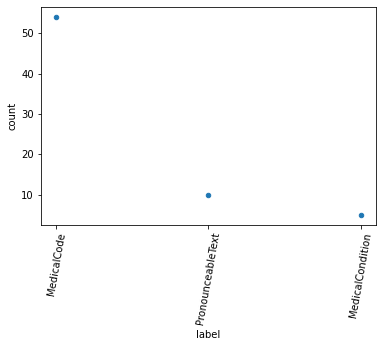

********** ********** Bar Chart ********** **********


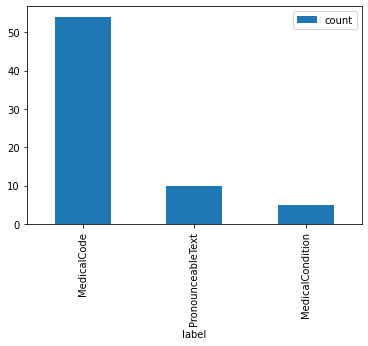

********** ********** Pie Chart ********** **********


<AxesSubplot:title={'center':'Pie Chart'}, ylabel='count'>

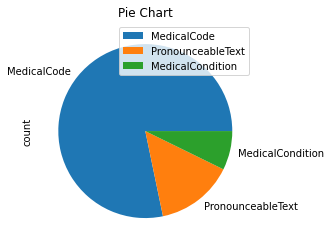

In [16]:
print("********** ********** Scatter Chart ********** **********")
df2.plot(x ='label', y='count', kind = 'scatter', rot=80)
plt.show()

print("********** ********** Bar Chart ********** **********")
df2.plot(x ='label', y='count', kind = 'bar')
plt.show()

print("********** ********** Pie Chart ********** **********")

my_labels=['MedicalCode','PronounceableText','MedicalCondition']
df2.plot.pie(title="Pie Chart",y='count',figsize=(4,4),labels=my_labels)